<a href="https://colab.research.google.com/github/harshdsdh/MLstuff/blob/master/austenGenerativetext_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf 

# Download and import the MIT 6.S191 package
!pip install mitdeeplearning
import mitdeeplearning as mdl

# Import all remaining packages
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
!apt-get install abcmidi timidity > /dev/null 2>&1

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert len(tf.config.list_physical_devices('GPU')) > 0

In [0]:
import pandas as pd


In [0]:
filename = '/content/missAusten.txt'
raw_text = open(filename,'r',encoding='utf-8').read()
raw_text= raw_text.lower()

In [27]:
vocab = sorted(set(raw_text))
print("there are",len(vocab)," unique characters in the dataset")

there are 66  unique characters in the dataset


In [0]:
char2idx = {u:i for i,u in enumerate(vocab)}
idx2char = np.array(vocab)

In [0]:
print("{")
for char,_ in zip(char2idx, range(20)):
  print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

In [0]:
def vectorized_string(string):
  arr=[]
  for i in string:
    arr.append(char2idx[i])
  return np.array(arr)
vectorized_book = vectorized_string(raw_text)

In [32]:
print ('{} ---- characters mapped to int ----> {}'.format(repr(raw_text[:10]), vectorized_book[:10]))

'\ufeff\nthe proj' ---- characters mapped to int ----> [65  0 50 38 35  1 46 48 45 40]


In [0]:
def get_batch(vectorized_book, seq_length, batch_size):
  n=vectorized_book.shape[0]-1
  idx = np.random.choice(n-seq_length, batch_size)
  input_batch = [vectorized_book[i:i+seq_length] for i in idx]
  output_batch = [vectorized_book[i+1:i+seq_length+1] for i in idx]
  
  x_batch = np.reshape(input_batch,[batch_size,seq_length])
  y_batch = np.reshape(output_batch,[batch_size,seq_length])
  return x_batch,y_batch

In [49]:
x_batch, y_batch =  get_batch(vectorized_book, seq_length=5,batch_size=1)
for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step   0
  input: 49 ('s')
  expected output: 1 (' ')
Step   1
  input: 1 (' ')
  expected output: 38 ('h')
Step   2
  input: 38 ('h')
  expected output: 31 ('a')
Step   3
  input: 31 ('a')
  expected output: 44 ('n')
Step   4
  input: 44 ('n')
  expected output: 34 ('d')


In [0]:
def LSTM(rnn_units):
  return tf.keras.layers.LSTM(
      rnn_units,
      return_sequences=True,
      recurrent_initializer="glorot_uniform",
      recurrent_activation = 'sigmoid',
      stateful=True,
  )

In [0]:
def build_model(vocab_size,embedding_dim,rnn_units,batch_size):
  model = tf.keras.Sequential([
                               tf.keras.layers.Embedding(vocab_size,embedding_dim,batch_input_shape=[batch_size,None]),
                               LSTM(rnn_units),
                               tf.keras.layers.Dense(vocab_size)
  ])
  return model
model = build_model(len(vocab), embedding_dim=256, rnn_units=1024, batch_size=32)

In [52]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (32, None, 256)           16896     
_________________________________________________________________
lstm_1 (LSTM)                (32, None, 1024)          5246976   
_________________________________________________________________
dense_1 (Dense)              (32, None, 66)            67650     
Total params: 5,331,522
Trainable params: 5,331,522
Non-trainable params: 0
_________________________________________________________________


In [53]:
x, y = get_batch(vectorized_book, seq_length=100, batch_size=32)
pred = model(x)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

Input shape:       (32, 100)  # (batch_size, sequence_length)
Prediction shape:  (32, 100, 66) # (batch_size, sequence_length, vocab_size)


In [54]:
y.shape

(32, 100)

In [55]:
sampled_indices = tf.random.categorical(pred[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
sampled_indices

array([18, 42, 65,  6, 22, 45, 13, 51, 30,  2, 27, 54, 40, 15, 63,  1, 14,
       35, 50,  6, 17,  9, 10, 61,  0, 18,  4, 38, 44, 11, 62, 22, 45, 26,
       11, 19, 55, 38,  0, 13, 48, 55, 45, 58, 44, 27, 36, 13,  7, 14, 18,
       50, 27, 39, 61, 41, 50,  6, 38, 20, 36,  6, 34, 13, 49, 39, 45, 25,
       21,  8, 53, 53, 49, 49, 27, 12,  7, 52, 37,  4, 49, 59, 58, 37, 48,
       42, 48, 48,  1, 59, 38, 64, 63, 28, 32,  7,  7, 19, 24, 14])

In [56]:
print("Input: \n", repr("".join(idx2char[x[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

Input: 
 'with equal pleasure, and then proceeded to relate\n      the particulars of their interview, with the'

Next Char Predictions: 
 "4l\ufeff'8o/u_!@xj1“ 0et'3*,‘\n4$hn-’8o?-5yh\n/ryoén@f/(04t@i‘kt'h6f'd/sio;7)wwss@.(vg$sêégrlrr êh”“[b((5:0"


In [57]:
y.shape, pred.shape

((32, 100), TensorShape([32, 100, 66]))

In [59]:
def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True) # TODO
  return loss

'''TODO: compute the loss using the true next characters from the example batch 
    and the predictions from the untrained model several cells above'''
example_batch_loss = compute_loss(y, pred) # TODO

print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, vocab_size)") 
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (32, 100, 66)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.190466


In [0]:
num_training_iterations = 3000  # Increase this to train longer
batch_size = 4  # Experiment between 1 and 64
seq_length = 50  # Experiment between 50 and 500
learning_rate = 5e-3  # Experiment between 1e-5 and 1e-1

# Model parameters: 
vocab_size = len(vocab)
embedding_dim = 256 
rnn_units = 1024  # Experiment between 1 and 2048

# Checkpoint location: 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

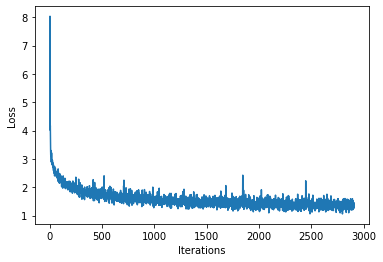

100%|██████████| 3000/3000 [00:59<00:00, 50.27it/s]


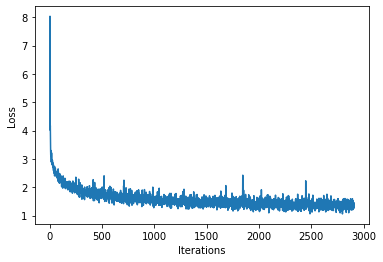

In [97]:
model  = build_model(vocab_size, embedding_dim,rnn_units, batch_size)
optimizer = tf.keras.optimizers.Adam(learning_rate,amsgrad=False,name='Adam')
def train_step(x,y):
  with tf.GradientTape() as tape:
    y_hat = model(x)
    loss = compute_loss(y,y_hat)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss
history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(vectorized_book, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)

  # Update the progress bar
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:     
    model.save_weights(checkpoint_prefix)
    
# Save the trained model and the weights
model.save_weights(checkpoint_prefix)


In [100]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1,None]))
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (1, None, 256)            16896     
_________________________________________________________________
lstm_11 (LSTM)               (1, None, 1024)           5246976   
_________________________________________________________________
dense_11 (Dense)             (1, None, 66)             67650     
Total params: 5,331,522
Trainable params: 5,331,522
Non-trainable params: 0
_________________________________________________________________


In [0]:
def generate_text(model, start_string, generation_length=1000):
  # Evaluation step (generating ABC text using the learned RNN model)

  '''TODO: convert the start string to numbers (vectorize)'''
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Here batch size == 1
  model.reset_states()
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
      '''TODO: evaluate the inputs and generate the next character predictions'''
      predictions = model(input_eval)
      
      # Remove the batch dimension
      predictions = tf.squeeze(predictions, 0)
      
      '''TODO: use a multinomial distribution to sample'''
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      
      # Pass the prediction along with the previous hidden state
      #   as the next inputs to the model
      input_eval = tf.expand_dims([predicted_id], 0)
      
      '''TODO: add the predicted character to the generated text!'''
      # Hint: consider what format the prediction is in vs. the output
      text_generated.append(idx2char[predicted_id])
    
  return (start_string + ''.join(text_generated))

In [104]:
generated_text = generate_text(model, start_string="the", generation_length=500) 

100%|██████████| 500/500 [00:02<00:00, 213.18it/s]


In [105]:
print(generated_text)

them. i which siles, her estates, meryt
      of sixe disposited. for mr. darcy to herger 59

    good of confessed man.
      to with espedit, and scarcely of her repaging on the law the hearth silence on she ent to be in a matter,
      never the
      to dispokence of such ever sadely attention, and every a
      from she was ocal and it had hand.”

      “y
      you say in sufferent at thinquilly in a
      she expressed not tempt to to know, three in your ampetal her may an digracital eagerin
